# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.97KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

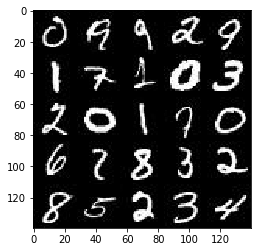

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

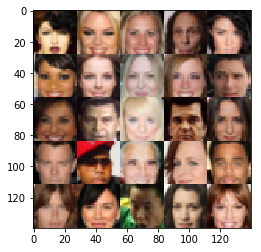

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = 'real')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name = 'z')
    lr = tf.placeholder(tf.float32, name = 'learning_rate')

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [54]:
def discriminator(images, reuse = False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse = reuse):
        # input is 28x28x dim, where dim == 1 or dim == 3
        c1 = tf.layers.conv2d(images, 128, 5, strides = 2, padding = 'same')
        lrelu1 = tf.maximum(alpha * c1, c1)
        # out: 14x14x128
       
        # in: 14x14x128
        c2 = tf.layers.conv2d(lrelu1, 256, 5, strides = 2, padding = 'same')
        b2 = tf.layers.batch_normalization(c2, training = True)
        lrelu2 = tf.maximum(alpha * b2, b2)
        # out: 7x7x256
         
        # in: 7x7x256
        c3 = tf.layers.conv2d(lrelu2, 512, 5, strides = 2, padding = 'same')
        b3 = tf.layers.batch_normalization(c3, training = True)
        lrelu3 = tf.maximum(alpha * b3, b3)
        # out: 4x4x512
             
        # in: 4x4x512
        flat = tf.reshape(lrelu3, [-1, 4 * 4 * 512])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

#    with tf.variable_scope('discriminator', reuse = reuse):
#        # input is 28x28x dim, where dim == 1 or dim == 3
#        c1 = tf.layers.conv2d(images, 128, 5, strides = 2, padding = 'same')
#        lrelu1 = tf.maximum(alpha * c1, c1)
        # out: 14x14x128
        
        # in: 14x14x128
#        c2 = tf.layers.conv2d(lrelu1, 256, 5, strides = 2, padding = 'same')
#        b2 = tf.layers.batch_normalization(c2, training = True)
#        lrelu2 = tf.maximum(alpha * b2, b2)
        # out: 7x7x256
         
        # in: 7x7x256
#        c3 = tf.layers.conv2d(lrelu2, 512, 5, strides = 2, padding = 'same')
#        b3 = tf.layers.batch_normalization(c3, training = True)
#        lrelu3 = tf.maximum(alpha * b3, b3)
        # out: 4x4x512
             
        # in: 4x4x512
#        flat = tf.reshape(lrelu3, [-1, 4 * 4 * 512])
#        logits = tf.layers.dense(flat, 1)
#        out = tf.sigmoid(logits)        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [55]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train):
        fc1 = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(fc1, [-1, 4, 4, 512])
        b1 = tf.layers.batch_normalization(x1, training = is_train)
        lrelu1 = tf.maximum(alpha * b1, b1)
              
        # in: 4x4x512
        c2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, strides = 2, padding = 'same')
        b2 = tf.layers.batch_normalization(c2, training = is_train)
        lrelu2 = tf.maximum(alpha * b2, b2)
        # out: 8x8x256
        
        # in: 8x8x256
        c3 = tf.layers.conv2d_transpose(lrelu2, 128, 5, strides = 2, padding = 'same')
        b3 = tf.layers.batch_normalization(c3, training = is_train)
        lrelu3 = tf.maximum(alpha * b3, b3)
        # out: 16x16x128
        
        # in: 16x16x126
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 5, strides = 2, padding = 'same')
        # out: 32x32xout_channel_dim
 
        # Now we have 32x32x out_channel_dim
        # We crop the image now to 28x28x out_channel_dim
        logits = tf.slice(logits, begin = [0, 2, 2, 0], size = [-1, 28, 28, out_channel_dim])
    
        # Now we have 28x28x out_channel_dim
        out = tf.tanh(logits)
        
#    with tf.variable_scope('generator', reuse = not is_train):
#        fc1 = tf.layers.dense(z, 2 * 2 * 1024)
#        x1 = tf.reshape(fc1, [-1, 2, 2, 1024])
#
#       b1 = tf.layers.batch_normalization(x1, training = is_train)
#        lrelu1 = tf.maximum(alpha * b1, b1)
              
#        # in: 2x2x1024
#        c2 = tf.layers.conv2d_transpose(lrelu1, 512, 5, strides = 2, padding = 'same')
#        b2 = tf.layers.batch_normalization(c2, training = is_train)
#        lrelu2 = tf.maximum(alpha * b2, b2)
        # out: 4x4x512
        
        # in: 4x4x512
#        c3 = tf.layers.conv2d_transpose(lrelu2, 256, 4, strides = 1, padding = 'valid')
#        b3 = tf.layers.batch_normalization(c3, training = is_train)
#        lrelu3 = tf.maximum(alpha * b3, b3)
        # out: 7x7x256

#        print(c3)
        
        # in: 7x7x256
#        c4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, strides = 2, padding ='same')
#        b4 = tf.layers.batch_normalization(c4, training = is_train)
#        lrelu4 = tf.maximum(alpha * b4, b4)
        # out: 14x14x128
    
        # in: 14x14x128
#        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, strides = 2, padding = 'same')
        # out: 28x28xout_channel_dim
 
        # Now we have 28x28x out_channel_dim
#        out = tf.tanh(logits)        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [56]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_out = generator(input_z, out_channel_dim)
    d_real_out, d_real_logits = discriminator(input_real * 2) # must use * 2 here to scale image values to [-1,1] 
    d_fake_out, d_fake_logits = discriminator(g_out, reuse = True)
    
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logits,
                                                                         labels = tf.ones_like(d_real_out)))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits,
                                                                         labels = tf.zeros_like(d_fake_out)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits,
                                                                    labels = tf.ones_like(d_fake_out)))
    
    return d_real_loss + d_fake_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [57]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    d_vars = []
    g_vars = []
    for var in tf.trainable_variables():
        if var.name.startswith('discriminator'):
            d_vars.append(var)
        elif var.name.startswith('generator'):
            g_vars.append(var)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="discriminator")):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="generator")):    
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [58]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    dim = 1
    if data_image_mode == 'RGB':
        dim = 3
    input_real, input_z, lr = model_inputs(28, 28, dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    n = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                n += 1
                
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if n % 100 == 0:
                    train_g_loss = g_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_d_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    print("epoch {}/{}: ".format(epoch_i, epoch_count),
                          "D loss: {:.4f}; ".format(train_d_loss),
                          "G loss: {:.4f}".format(train_g_loss))
                    
                    show_generator_output(sess, 25, input_z, dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 0/2:  D loss: 1.5684;  G loss: 0.5636


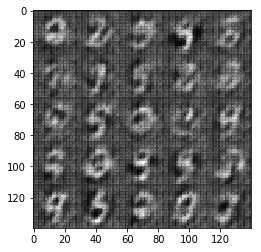

epoch 0/2:  D loss: 1.3991;  G loss: 0.5700


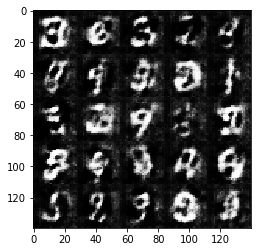

epoch 0/2:  D loss: 1.7456;  G loss: 0.9078


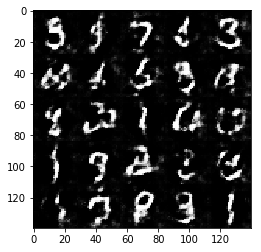

epoch 0/2:  D loss: 1.4513;  G loss: 0.7408


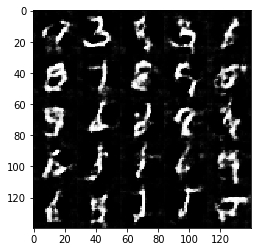

epoch 0/2:  D loss: 1.7436;  G loss: 0.3280


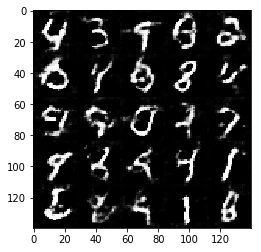

epoch 0/2:  D loss: 1.3594;  G loss: 0.6631


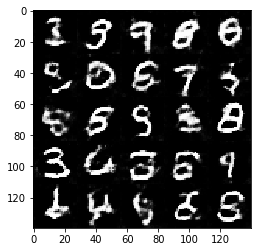

epoch 0/2:  D loss: 1.3817;  G loss: 0.4240


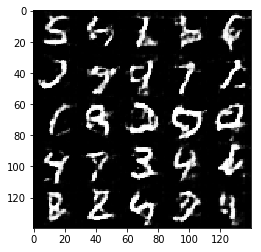

epoch 0/2:  D loss: 1.2048;  G loss: 0.6397


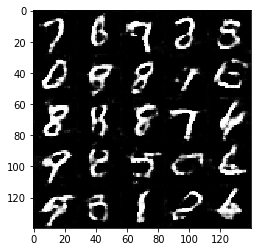

epoch 0/2:  D loss: 1.2604;  G loss: 0.5456


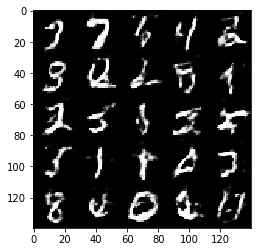

epoch 0/2:  D loss: 0.9525;  G loss: 1.2637


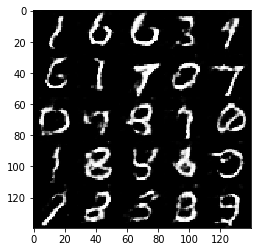

epoch 0/2:  D loss: 1.4039;  G loss: 0.3965


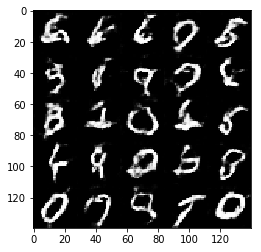

epoch 0/2:  D loss: 1.6042;  G loss: 0.2872


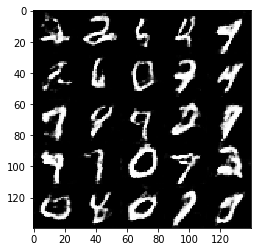

epoch 0/2:  D loss: 1.5520;  G loss: 1.2927


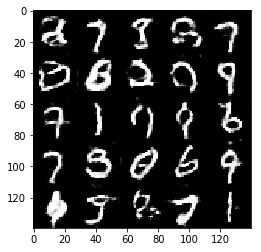

epoch 0/2:  D loss: 1.2205;  G loss: 0.7348


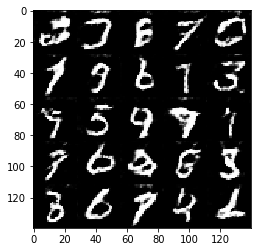

epoch 0/2:  D loss: 1.1039;  G loss: 0.9224


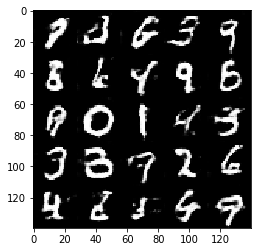

epoch 0/2:  D loss: 1.5601;  G loss: 0.3247


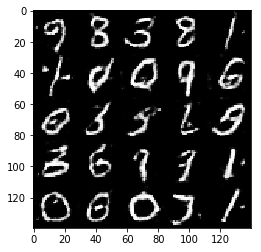

epoch 0/2:  D loss: 1.3949;  G loss: 0.4527


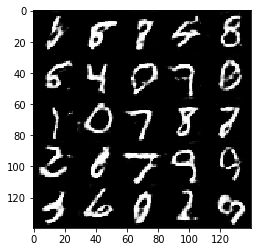

epoch 0/2:  D loss: 1.5667;  G loss: 0.3720


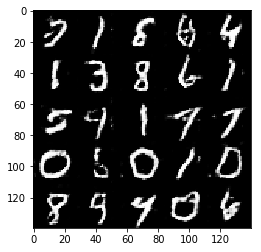

epoch 1/2:  D loss: 1.2888;  G loss: 0.4986


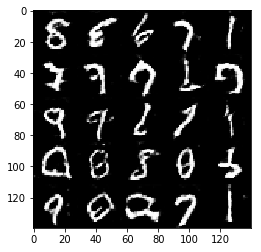

epoch 1/2:  D loss: 1.3588;  G loss: 0.5200


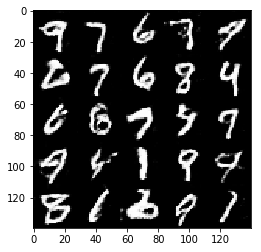

epoch 1/2:  D loss: 1.8596;  G loss: 0.2946


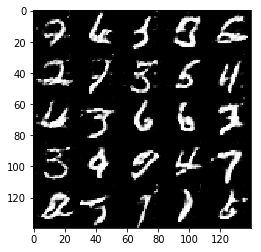

epoch 1/2:  D loss: 1.0856;  G loss: 0.9627


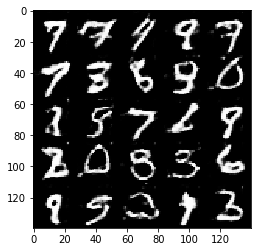

epoch 1/2:  D loss: 0.9286;  G loss: 1.2653


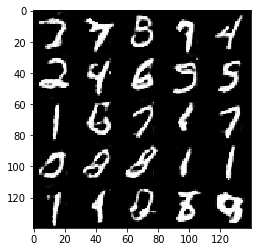

epoch 1/2:  D loss: 2.2403;  G loss: 0.1544


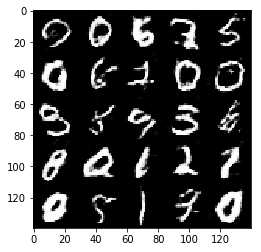

epoch 1/2:  D loss: 1.5066;  G loss: 0.4175


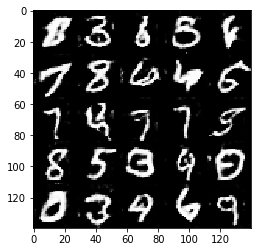

epoch 1/2:  D loss: 1.5424;  G loss: 0.4601


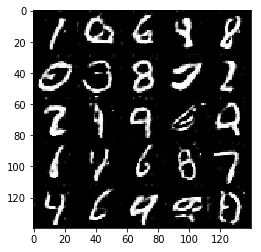

epoch 1/2:  D loss: 2.1863;  G loss: 0.1938


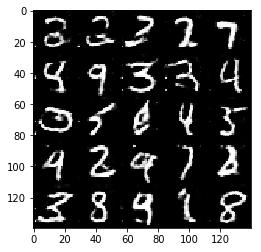

epoch 1/2:  D loss: 0.8700;  G loss: 1.0156


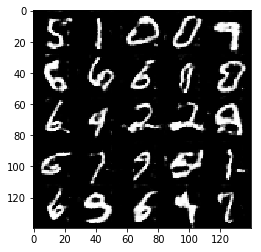

epoch 1/2:  D loss: 1.3831;  G loss: 0.4298


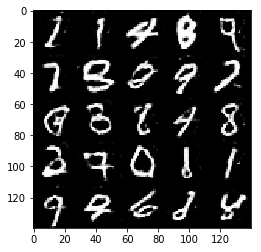

epoch 1/2:  D loss: 1.1181;  G loss: 1.9106


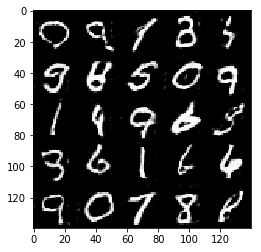

epoch 1/2:  D loss: 1.6720;  G loss: 0.3849


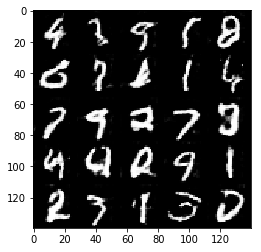

epoch 1/2:  D loss: 1.0450;  G loss: 0.5685


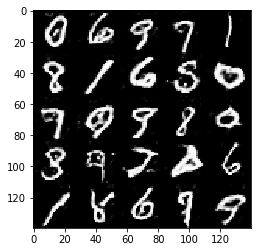

epoch 1/2:  D loss: 2.0276;  G loss: 0.2132


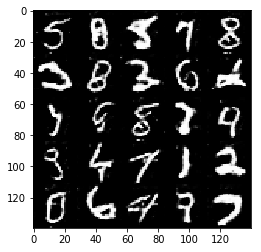

epoch 1/2:  D loss: 1.6784;  G loss: 0.2889


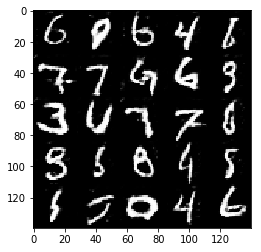

epoch 1/2:  D loss: 0.6252;  G loss: 1.7353


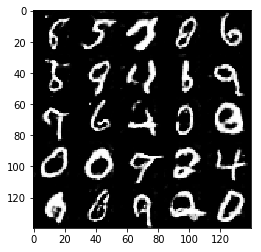

epoch 1/2:  D loss: 1.2163;  G loss: 0.8299


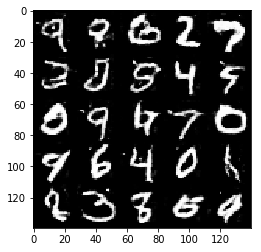

epoch 1/2:  D loss: 1.6419;  G loss: 0.3670


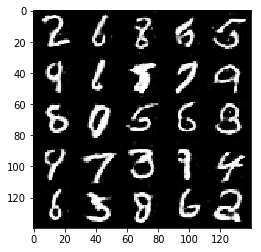

In [62]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 0/1:  D loss: 1.7034;  G loss: 0.5235


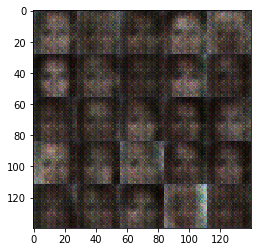

epoch 0/1:  D loss: 1.8481;  G loss: 0.3326


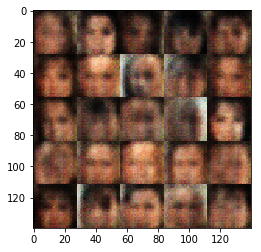

epoch 0/1:  D loss: 1.4764;  G loss: 0.5629


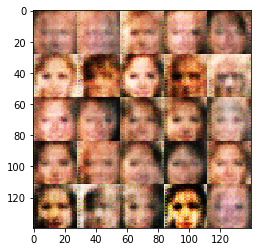

epoch 0/1:  D loss: 1.6401;  G loss: 0.4197


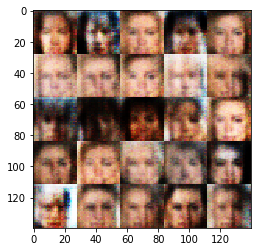

epoch 0/1:  D loss: 1.4955;  G loss: 0.6341


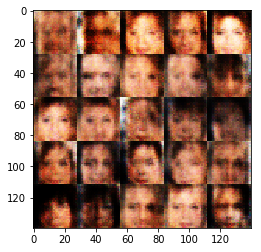

epoch 0/1:  D loss: 1.5114;  G loss: 0.6012


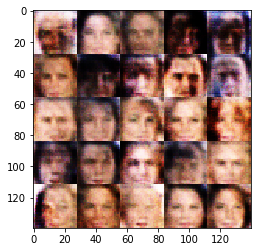

epoch 0/1:  D loss: 1.6108;  G loss: 0.5473


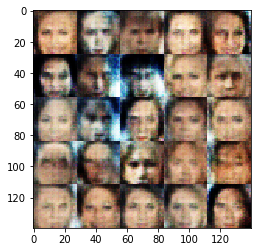

epoch 0/1:  D loss: 1.4258;  G loss: 0.6553


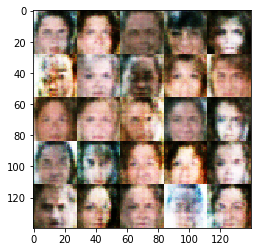

epoch 0/1:  D loss: 1.4758;  G loss: 0.6593


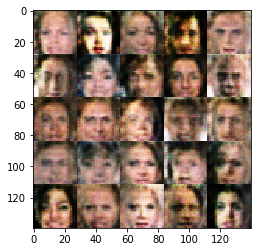

epoch 0/1:  D loss: 1.5316;  G loss: 0.5811


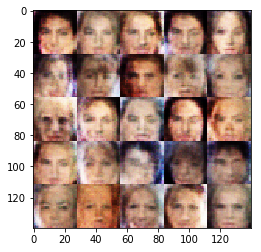

epoch 0/1:  D loss: 1.4921;  G loss: 0.6472


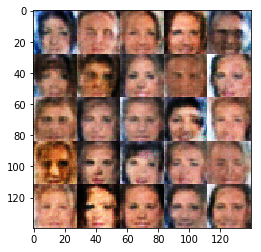

epoch 0/1:  D loss: 1.4694;  G loss: 0.5848


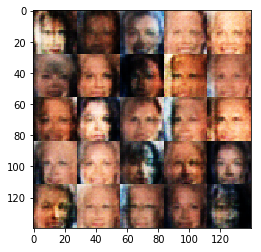

epoch 0/1:  D loss: 1.4612;  G loss: 0.5988


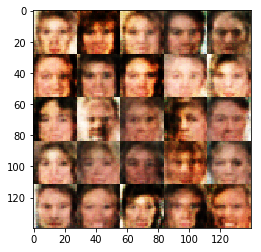

epoch 0/1:  D loss: 1.3956;  G loss: 0.6221


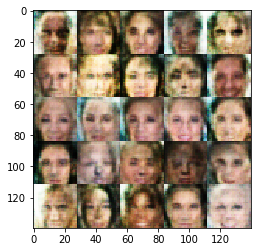

epoch 0/1:  D loss: 1.4394;  G loss: 0.6218


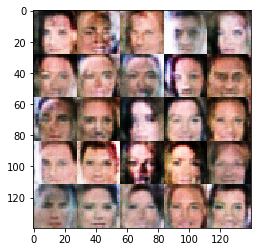

epoch 0/1:  D loss: 1.4975;  G loss: 0.6743


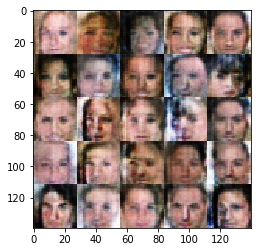

epoch 0/1:  D loss: 1.4639;  G loss: 0.6002


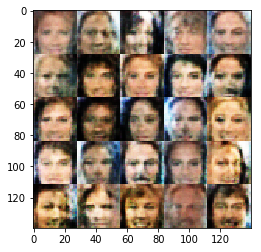

epoch 0/1:  D loss: 1.3948;  G loss: 0.6992


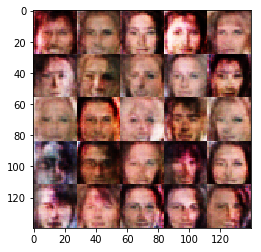

epoch 0/1:  D loss: 1.4397;  G loss: 0.6341


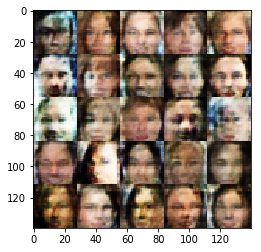

epoch 0/1:  D loss: 1.4588;  G loss: 0.7077


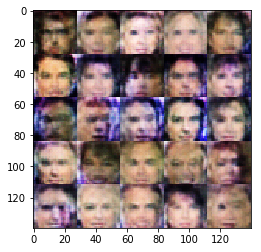

epoch 0/1:  D loss: 1.3912;  G loss: 0.6371


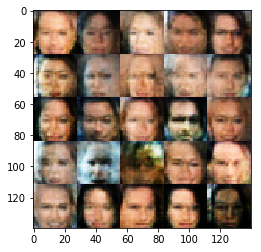

epoch 0/1:  D loss: 1.4288;  G loss: 0.5550


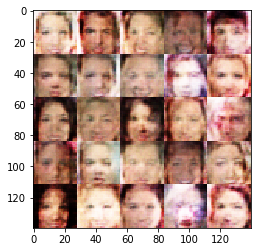

epoch 0/1:  D loss: 1.4342;  G loss: 0.7007


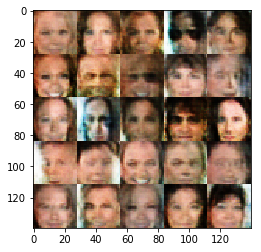

epoch 0/1:  D loss: 1.4355;  G loss: 0.6387


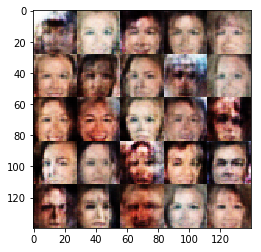

epoch 0/1:  D loss: 1.4353;  G loss: 0.6957


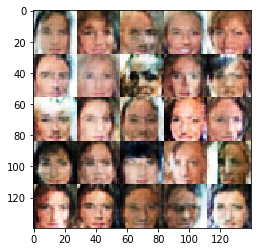

epoch 0/1:  D loss: 1.3680;  G loss: 0.7605


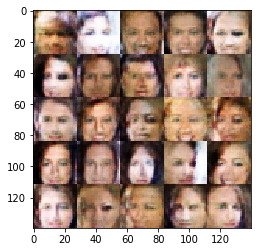

epoch 0/1:  D loss: 1.4708;  G loss: 0.5587


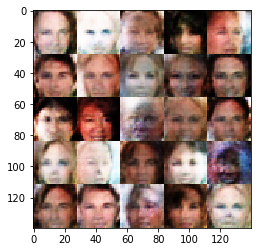

epoch 0/1:  D loss: 1.4557;  G loss: 0.6213


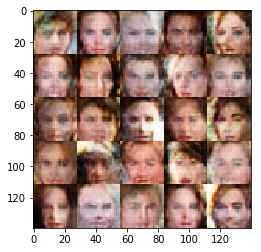

epoch 0/1:  D loss: 1.4820;  G loss: 0.6787


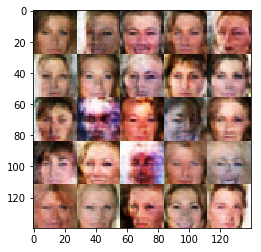

epoch 0/1:  D loss: 1.4795;  G loss: 0.5381


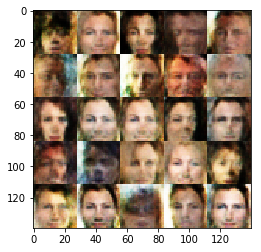

epoch 0/1:  D loss: 1.4268;  G loss: 0.6119


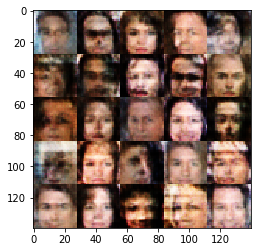

epoch 0/1:  D loss: 1.3726;  G loss: 0.7454


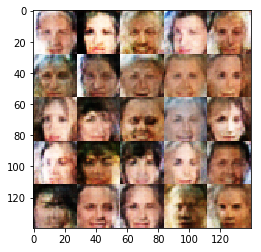

epoch 0/1:  D loss: 1.4765;  G loss: 0.5692


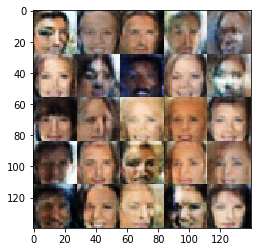

epoch 0/1:  D loss: 1.4003;  G loss: 0.5544


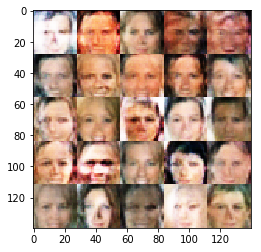

epoch 0/1:  D loss: 1.4535;  G loss: 0.6934


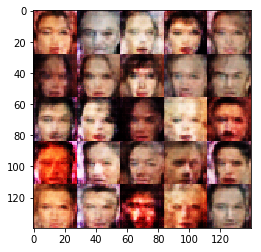

epoch 0/1:  D loss: 1.4773;  G loss: 0.6331


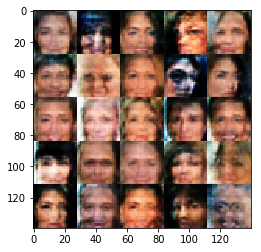

epoch 0/1:  D loss: 1.4414;  G loss: 0.5699


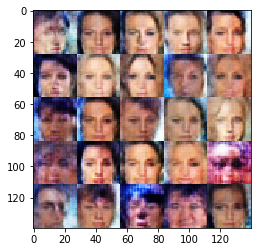

epoch 0/1:  D loss: 1.4913;  G loss: 0.5641


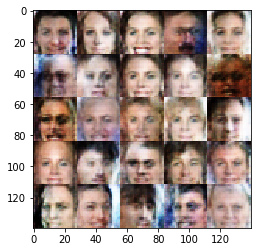

epoch 0/1:  D loss: 1.4685;  G loss: 0.6107


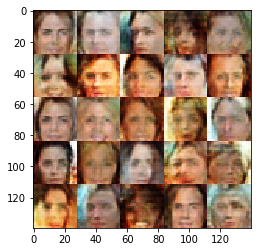

epoch 0/1:  D loss: 1.4550;  G loss: 0.6584


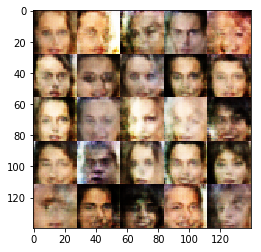

epoch 0/1:  D loss: 1.4301;  G loss: 0.5904


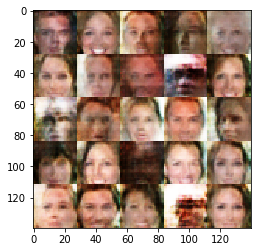

epoch 0/1:  D loss: 1.6002;  G loss: 0.5790


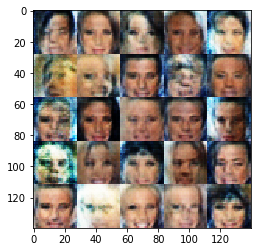

epoch 0/1:  D loss: 1.4598;  G loss: 0.6094


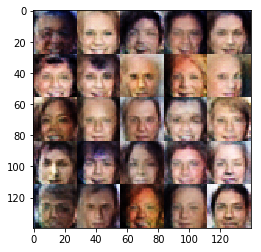

epoch 0/1:  D loss: 1.4436;  G loss: 0.6672


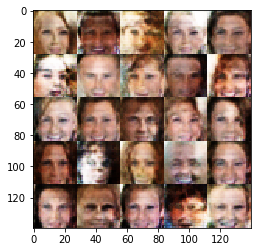

epoch 0/1:  D loss: 1.4110;  G loss: 0.5791


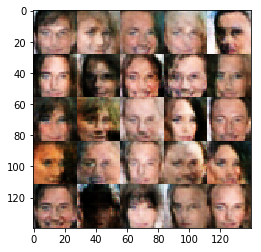

epoch 0/1:  D loss: 1.4666;  G loss: 0.5797


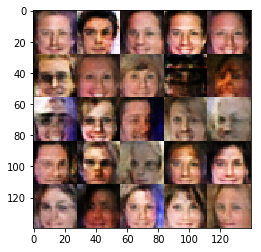

epoch 0/1:  D loss: 1.4153;  G loss: 0.6872


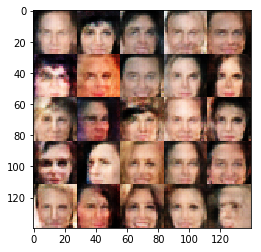

epoch 0/1:  D loss: 1.4339;  G loss: 0.6351


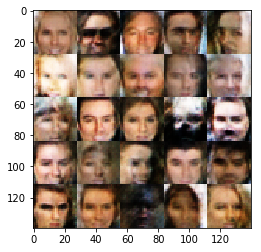

epoch 0/1:  D loss: 1.4220;  G loss: 0.6362


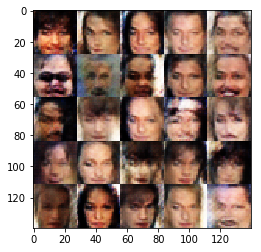

epoch 0/1:  D loss: 1.4510;  G loss: 0.6311


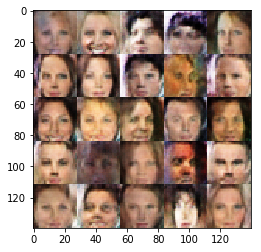

epoch 0/1:  D loss: 1.4553;  G loss: 0.6766


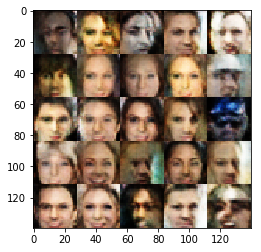

epoch 0/1:  D loss: 1.4128;  G loss: 0.6707


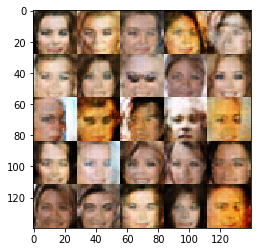

epoch 0/1:  D loss: 1.4238;  G loss: 0.6375


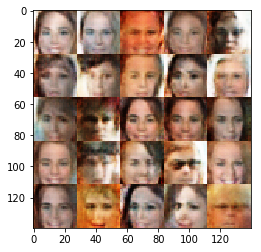

epoch 0/1:  D loss: 1.4012;  G loss: 0.6324


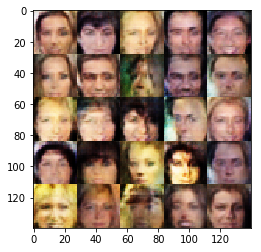

epoch 0/1:  D loss: 1.4142;  G loss: 0.6205


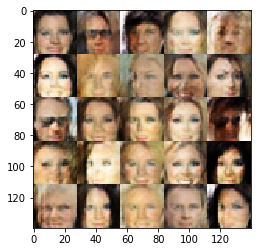

epoch 0/1:  D loss: 1.4510;  G loss: 0.5421


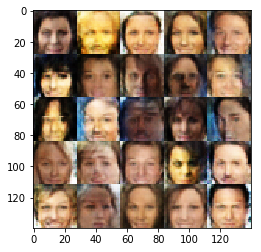

epoch 0/1:  D loss: 1.4082;  G loss: 0.6868


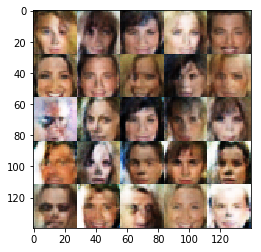

epoch 0/1:  D loss: 1.5083;  G loss: 0.5687


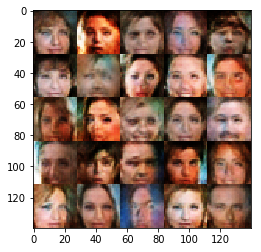

epoch 0/1:  D loss: 1.4323;  G loss: 0.6944


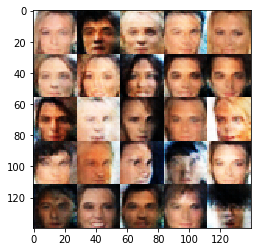

epoch 0/1:  D loss: 1.4188;  G loss: 0.6133


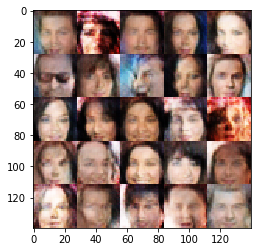

epoch 0/1:  D loss: 1.5047;  G loss: 0.6070


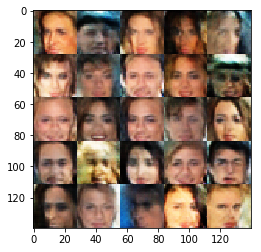

epoch 0/1:  D loss: 1.4668;  G loss: 0.5235


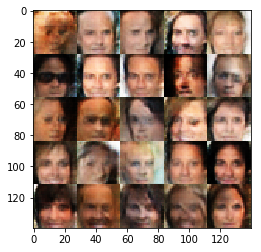

epoch 0/1:  D loss: 1.4620;  G loss: 0.6531


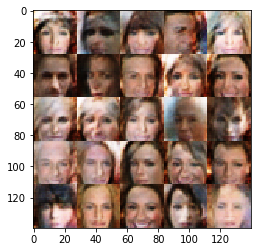

In [61]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.